# **Shopper Spectrum Product Recommendation & Customer Segmentation**

---
**PROJECT TYPE: UNSUPERVISED MACHINE LEARNING CLUSTERING**



---
CONTRIBUTION: INDIVIDUAL (ASHUTOSH RANE)



**PROBLEM STATEMENT:**


---

The global e-commerce industry generates vast amounts of transaction data daily, offering
valuable insights into customer purchasing behaviors. Analyzing this data is essential for
identifying meaningful customer segments and recommending relevant products to enhance
customer experience and drive business growth. This project aims to examine transaction
data from an online retail business to uncover patterns in customer purchase behavior,
segment customers based on Recency, Frequency, and Monetary (RFM) analysis, and
develop a product recommendation system using collaborative filtering techniques.

Streamlit Link: https://shopper-spectrum-wjckwdmdrqwylovssukvbq.streamlit.app/

**PROJECT SUMMARY:**


---
**Objective:**

To segment customers and recommend similar products using transactional data through unsupervised learning techniques.


---
🔍 Dataset Overview:

1. Rows: 541,909 transactions

2. Columns: 8 (InvoiceNo, StockCode, Description, Quantity, InvoiceDate, UnitPrice, CustomerID, Country)

3. Size: ~45 MB


---



🔧 Key Steps:

1. Data Cleaning & Feature Engineering

2. Removed null & duplicate entries

3. Extracted InvoiceDate, Time, Hour, Month, and Weekday

4. Created TotalPrice, InvoiceTotal, UniqueItems


---



Exploratory Data Analysis (EDA)

1. Advanced visualizations for top products, countries, customer behavior

2. Identified patterns in frequency, recency, and spending

---

Customer Segmentation (RFM + Clustering)

1. Applied RFM (Recency, Frequency, Monetary) analysis

2. Used KMeans, DBSCAN, and Agglomerative Clustering

3. Compared and interpreted clusters using summary statistics and 3D visualizations

4. Dynamically labeled clusters (e.g., High-Value, Regular, At-Risk)
---

Product Recommendation

1. Built item-based collaborative filtering model

2. Used cosine similarity on user-product matrix

---

🚀 Deployment: Streamlit App

App Features:

1. Product Recommendation Module
Users enter a product name and receive 5 similar product suggestions.

2. Customer Segmentation Module
Users input Recency, Frequency, and Monetary values to see their predicted customer segment.

---

📦 Saved Files for App

1. kmeans_rfm_model.pkl

2. rfm_scaler.pkl

3. rfm_clustered.csv

4. product_lookup.csv

5. item_similarity_matrix.pkl (hosted via Google Drive)

6. cluster_label_map.pkl

---







## **1. LOADING LIBRARIES**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import datetime as dt
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler, normalize
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/online_retail.csv", encoding='ISO-8859-1')

## **2. STUDYING THE METADATA AND DATASET INSPECTION**

In [ ]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2022-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2022-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2022-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2022-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2022-12-01 08:26:00,3.39,17850.0,United Kingdom


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [ ]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [ ]:
df.isnull().sum()

,0
InvoiceNo,0
StockCode,0
Description,1454
Quantity,0
InvoiceDate,0
UnitPrice,0
CustomerID,135080
Country,0


In [ ]:
df.duplicated().sum()

np.int64(5268)

## **3. DATA CLEANING & FEATURE ENGINEERING**

In [ ]:
df['InvoiceNo'] = df['InvoiceNo'].astype(str).str.strip()
df['StockCode'] = df['StockCode'].astype(str).str.strip()
df = df.dropna(subset=['CustomerID', 'Description'])
df = df[~df['InvoiceNo'].str.startswith('C')]
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]
df.drop_duplicates(inplace=True)  # Removed 5268 duplicate rows
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['CustomerID'] = df['CustomerID'].astype(int)
df.reset_index(drop=True, inplace=True)

In [ ]:
df['InvoiceDay'] = df['InvoiceDate'].dt.date
df['InvoiceTime'] = df['InvoiceDate'].dt.time
df['InvoiceHour'] = df['InvoiceDate'].dt.hour
df['InvoiceMonth'] = df['InvoiceDate'].dt.month
df['InvoiceWeekday'] = df['InvoiceDate'].dt.day_name()
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

In [ ]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceDay,InvoiceTime,InvoiceHour,InvoiceMonth,InvoiceWeekday,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2022-12-01 08:26:00,2.55,17850,United Kingdom,2022-12-01,08:26:00,8,12,Thursday,15.30
1,536365,71053,WHITE METAL LANTERN,6,2022-12-01 08:26:00,3.39,17850,United Kingdom,2022-12-01,08:26:00,8,12,Thursday,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2022-12-01 08:26:00,2.75,17850,United Kingdom,2022-12-01,08:26:00,8,12,Thursday,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2022-12-01 08:26:00,3.39,17850,United Kingdom,2022-12-01,08:26:00,8,12,Thursday,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2022-12-01 08:26:00,3.39,17850,United Kingdom,2022-12-01,08:26:00,8,12,Thursday,20.34


In [ ]:
invoice_totals = df.groupby('InvoiceNo')['TotalPrice'].sum().reset_index(name='InvoiceTotal')
invoice_items = df.groupby('InvoiceNo')['StockCode'].nunique().reset_index(name='UniqueItems')
df = df.merge(invoice_totals, on='InvoiceNo', how='left')
df = df.merge(invoice_items, on='InvoiceNo', how='left')

In [ ]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceDay,InvoiceTime,InvoiceHour,InvoiceMonth,InvoiceWeekday,TotalPrice,InvoiceTotal,UniqueItems
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2022-12-01 08:26:00,2.55,17850,United Kingdom,2022-12-01,08:26:00,8,12,Thursday,15.30,139.12,7
1,536365,71053,WHITE METAL LANTERN,6,2022-12-01 08:26:00,3.39,17850,United Kingdom,2022-12-01,08:26:00,8,12,Thursday,20.34,139.12,7
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2022-12-01 08:26:00,2.75,17850,United Kingdom,2022-12-01,08:26:00,8,12,Thursday,22.00,139.12,7
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2022-12-01 08:26:00,3.39,17850,United Kingdom,2022-12-01,08:26:00,8,12,Thursday,20.34,139.12,7
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2022-12-01 08:26:00,3.39,17850,United Kingdom,2022-12-01,08:26:00,8,12,Thursday,20.34,139.12,7


## **4. EXPLORATORY DATA ANALYSIS**

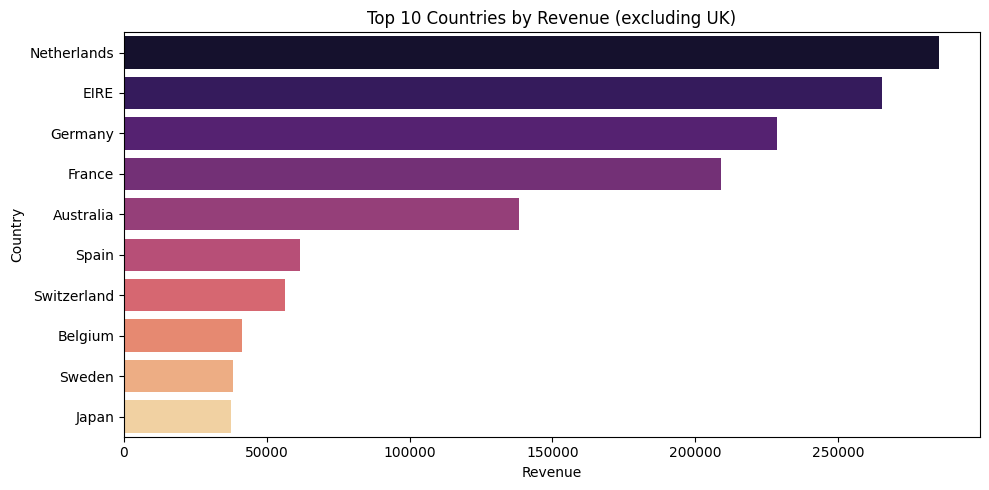

In [ ]:
# Country-wise revenue (excluding UK)
country_sales = df[df['Country'] != 'United Kingdom'].groupby('Country')['TotalPrice'].sum().sort_values(ascending=False).head(10)
plt.figure(figsize=(10,5))
sns.barplot(x=country_sales.values, y=country_sales.index, palette='magma')
plt.title('Top 10 Countries by Revenue (excluding UK)')
plt.xlabel('Revenue')
plt.ylabel('Country')
plt.tight_layout()
plt.show()

**Top 10 Countries by Revenue (Excluding UK)**

---

**Insight:**

1. Netherlands, EIRE, and Germany are the top 3 contributors to revenue after the UK, indicating strong customer bases.

2. These markets may represent high-value customer clusters, and should be targeted in promotions, loyalty programs, and localized campaigns.

3. Smaller contributors like Sweden and Japan may indicate niche audiences that could be tapped into with curated offerings or recommendations.

---

**Business Application:**

1. Helps prioritize international marketing and logistics.

2. Segmentation can be extended country-wise to customize campaigns.

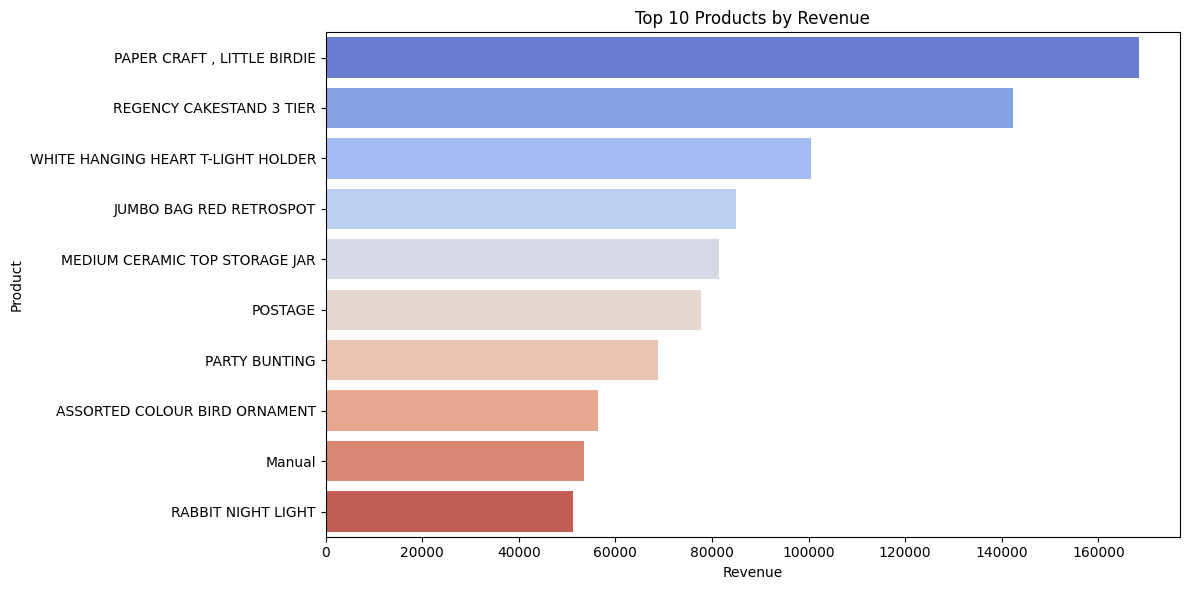

In [ ]:
# Top products
top_products = df.groupby('Description')['TotalPrice'].sum().sort_values(ascending=False).head(10)
plt.figure(figsize=(12,6))
sns.barplot(x=top_products.values, y=top_products.index, palette='coolwarm')
plt.title('Top 10 Products by Revenue')
plt.xlabel('Revenue')
plt.ylabel('Product')
plt.tight_layout()
plt.show()

**Top 10 Products by Revenue**


---


Insight:

1. Products like “PAPER CRAFT, LITTLE BIRDIE” and “REGENCY CAKESTAND 3 TIER” are generating the most revenue.

2. Many top-performing products fall into home decor and party items, suggesting seasonal or gift-oriented buying behavior.

3. Items like “POSTAGE” in top 10 indicates logistics charges are a non-trivial revenue stream.



---



Business Application:

1. These high-performing products can be anchors in collaborative filtering.

2. Use these as cross-sell or up-sell options in the product recommendation module.



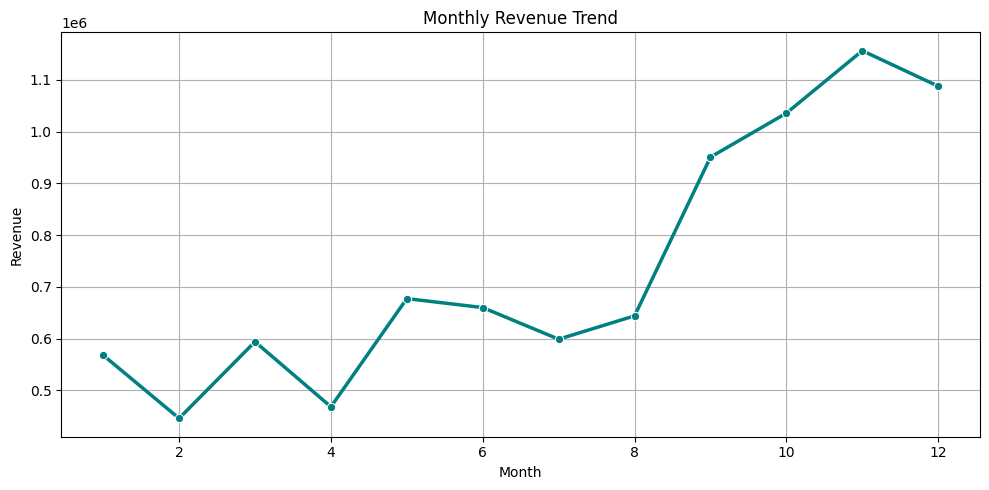

In [ ]:
# Monthly trend
monthly_sales = df.groupby('InvoiceMonth')['TotalPrice'].sum()
plt.figure(figsize=(10,5))
sns.lineplot(x=monthly_sales.index, y=monthly_sales.values, marker='o', linewidth=2.5, color='teal')
plt.title('Monthly Revenue Trend')
plt.xlabel('Month')
plt.ylabel('Revenue')
plt.grid(True)
plt.tight_layout()
plt.show()

**Monthly Revenue Trend**



---


Insight:

1. There's a significant surge in revenue in the last quarter (Sept–Dec), peaking in November.

2. This indicates strong seasonal buying behavior, likely due to holidays and gifting events.

3. Early-year (Feb–April) shows low activity, suggesting off-peak customer inactivity.

---

Business Application:

1. Time-based segmentation can be used to re-engage customers in slow months (via recency analysis).

2. Tailor promotions and inventory planning ahead of peak seasons.



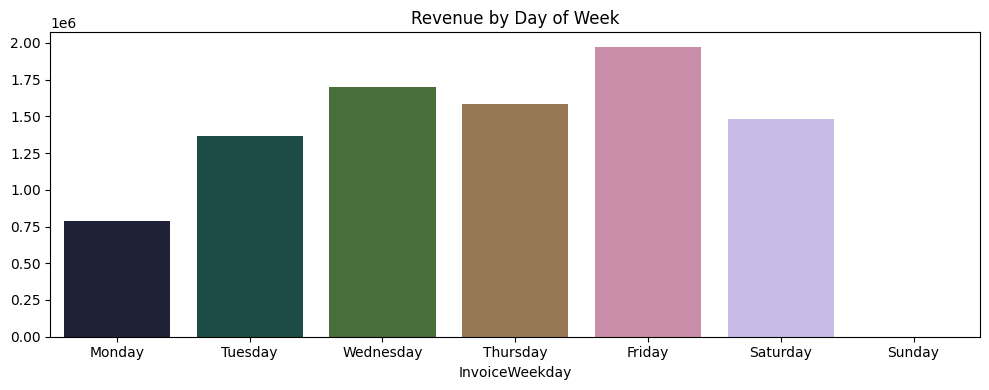

In [ ]:
# Day of week
weekday_sales = df.groupby('InvoiceWeekday')['TotalPrice'].sum().reindex(['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
plt.figure(figsize=(10,4))
sns.barplot(x=weekday_sales.index, y=weekday_sales.values, palette='cubehelix')
plt.title('Revenue by Day of Week')
plt.tight_layout()
plt.show()

**Revenue by Day of Week**


---


Insight:

1. Friday generates the highest revenue, followed by Wednesday and Thursday.

2. Monday is the lowest-performing day, possibly indicating slow start-of-week shopping activity.

3. Sunday has no recorded revenue, likely due to business closure or data absence.

---

Business Application:

1. Promotional campaigns or email marketing can be concentrated around mid-to-late week.

2. Use this to optimize advertising spend and plan flash sales on underperforming days like Monday.

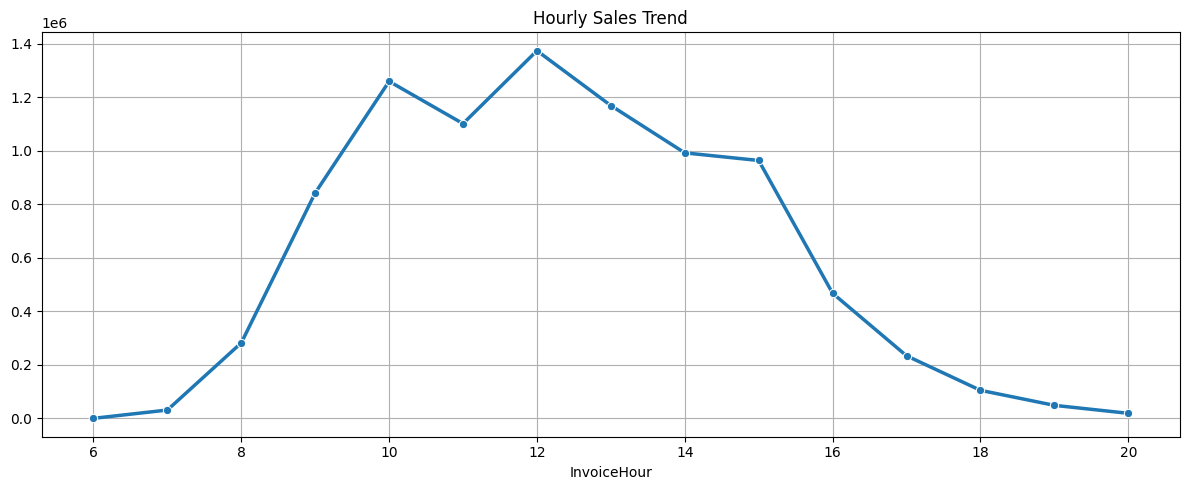

In [ ]:
# Hourly trend
hourly_sales = df.groupby('InvoiceHour')['TotalPrice'].sum()
plt.figure(figsize=(12,5))
sns.lineplot(x=hourly_sales.index, y=hourly_sales.values, marker='o', linewidth=2.5)
plt.title('Hourly Sales Trend')
plt.grid(True)
plt.tight_layout()
plt.show()

**Hourly Sales Trend**



---



Insight:

1. Sales start increasing sharply from 8 AM, peak at 12 PM, and gradually decline after 2 PM.

2. Very low activity is observed in early morning and post 5 PM, confirming business-hour centric purchases.

---

Business Application:

1. Use these patterns for targeted notifications and in-app promotions during peak shopping hours.

2. Helps in optimizing staffing and resource allocation in case of physical operations.



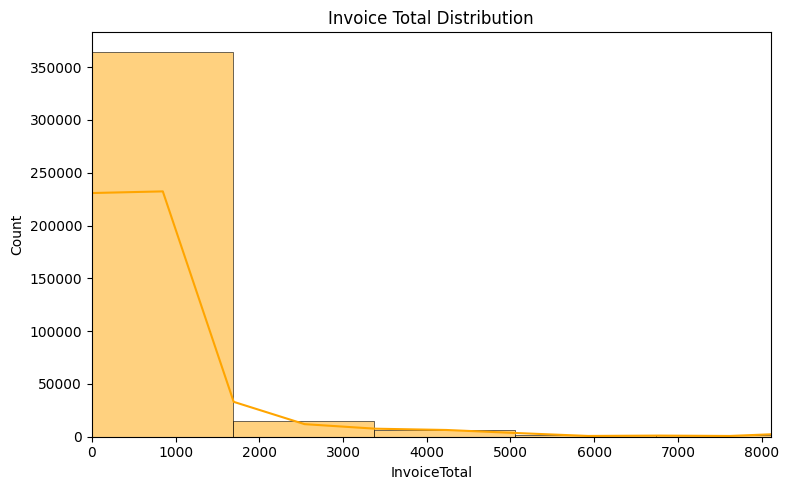

In [ ]:
# Basket size
plt.figure(figsize=(8,5))
sns.histplot(df['InvoiceTotal'], bins=100, kde=True, color='orange')
plt.title('Invoice Total Distribution')
plt.xlim(0, df['InvoiceTotal'].quantile(0.99))
plt.tight_layout()
plt.show()

**Invoice Total Distribution**



---


Insight:

1. The majority of invoices fall within the 0–1500 range, with a sharp drop-off afterwards.

2. Very few high-value invoices exist, showing the customer base mainly comprises small to mid-scale buyers.

---

Business Application:

1. Customer segmentation should be sensitive to this skew—focus on nurturing the long tail while recognizing high-ticket customers for loyalty programs.

2. Can inform pricing strategy, bundling, or minimum order thresholds for free shipping.



## **5. RECENCY, FREQUENCY & MONETARY CLUSTERING**

In [ ]:
snapshot_date = df['InvoiceDate'].max() + dt.timedelta(days=1)
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'InvoiceNo': 'nunique',
    'TotalPrice': 'sum'
}).reset_index()
rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']

In [ ]:
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[['Recency', 'Frequency', 'Monetary']])
rfm_scaled_df = pd.DataFrame(rfm_scaled, columns=['Recency', 'Frequency', 'Monetary'])

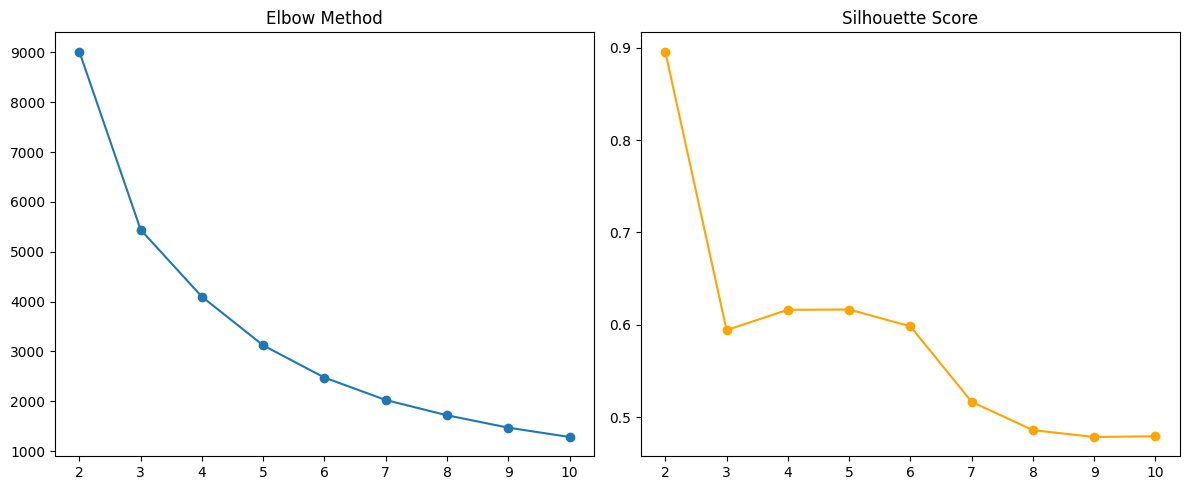

In [ ]:
# Elbow + Silhouette
inertia = []
silhouette = []
for k in range(2, 11):
    km = KMeans(n_clusters=k, n_init=10, random_state=42)
    km.fit(rfm_scaled_df)
    inertia.append(km.inertia_)
    silhouette.append(silhouette_score(rfm_scaled_df, km.labels_))

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(range(2,11), inertia, marker='o')
plt.title("Elbow Method")
plt.subplot(1,2,2)
plt.plot(range(2,11), silhouette, marker='o', color='orange')
plt.title("Silhouette Score")
plt.tight_layout()
plt.show()

## **Clustering Evaluation – KMeans**



---




Elbow Method (Left Plot)

1. Shows the inertia (within-cluster sum of squares) as the number of clusters increases.

2. A sharp decline is observed until k=4, after which the curve starts to flatten, forming an elbow.

Interpretation:
The optimal number of clusters is likely 4, as adding more clusters beyond this brings diminishing returns.

---

**Silhouette Score (Right Plot)**

1. Measures how well each data point fits within its cluster (range: -1 to 1).

2. Peak Silhouette Score is at k=2, but it drops significantly afterwards.

Interpretation:

Despite a higher score at k=2, it may be too broad for actionable segmentation.
A good trade-off between performance and detail is again k=4, where the score remains stable (~0.62).

---

Final Choice:

We proceed with k=4 clusters to balance interpretability, business utility, and clustering quality.



In [ ]:
# Apply KMeans
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
rfm['Cluster_KMeans'] = kmeans.fit_predict(rfm_scaled_df)

# Apply Agglomerative Clustering
agg = AgglomerativeClustering(n_clusters=4)
rfm['Cluster_Agg'] = agg.fit_predict(rfm_scaled_df)

# Apply DBSCAN
dbscan = DBSCAN(eps=1.1, min_samples=5)
rfm['Cluster_DBSCAN'] = dbscan.fit_predict(rfm_scaled_df)

In [ ]:
# Compare all clustering methods
methods = ['Cluster_KMeans', 'Cluster_Agg', 'Cluster_DBSCAN']
for method in methods:
    print(f"\n--- {method} Summary ---")
    print(rfm.groupby(method)[['Recency', 'Frequency', 'Monetary']].mean().round(2))
    print("Cluster Counts:")
    print(rfm[method].value_counts())


--- Cluster_KMeans Summary ---
                Recency  Frequency   Monetary
Cluster_KMeans                               
0                 43.70       3.68    1353.63
1                248.08       1.55     478.85
2                  7.38      82.54  127187.96
3                 15.50      22.33   12690.50
Cluster Counts:
Cluster_KMeans
0    3054
1    1067
3     204
2      13
Name: count, dtype: int64

--- Cluster_Agg Summary ---
             Recency  Frequency   Monetary
Cluster_Agg                               
0               6.73      83.47  111780.64
1              41.23       3.89    1479.41
2             241.41       1.64     518.62
3              14.63      24.44   14435.46
Cluster Counts:
Cluster_Agg
1    3042
2    1134
3     147
0      15
Name: count, dtype: int64

--- Cluster_DBSCAN Summary ---
                Recency  Frequency  Monetary
Cluster_DBSCAN                              
-1                40.16      57.38  76796.96
 0                92.93       3.88   1493.20
Cl

In [ ]:
# Create label map based on actual cluster statistics
cluster_stats = rfm.groupby('Cluster_KMeans')[['Recency', 'Frequency', 'Monetary']].mean()

label_map = {}
for cluster_id, row in cluster_stats.iterrows():
    if row['Frequency'] > 50 and row['Monetary'] > 50000:
        label_map[cluster_id] = "High-Value"
    elif row['Frequency'] > 20:
        label_map[cluster_id] = "Regular"
    elif row['Recency'] > 200:
        label_map[cluster_id] = "At-Risk"
    else:
        label_map[cluster_id] = "Occasional"

joblib.dump(label_map, "cluster_label_map.pkl")

# Assign Segment column using map
rfm['Segment'] = rfm['Cluster_KMeans'].map(label_map)

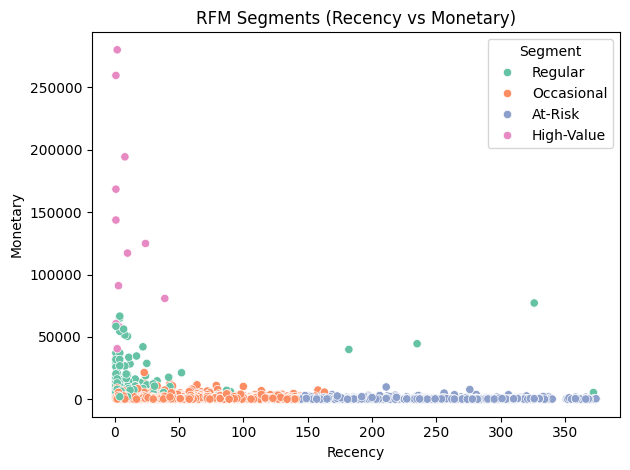

In [ ]:
# Visualize clusters
sns.scatterplot(data=rfm, x='Recency', y='Monetary', hue='Segment', palette='Set2')
plt.title("RFM Segments (Recency vs Monetary)")
plt.tight_layout()
plt.show()

Here are insights based on the **RFM Segments (Recency vs Monetary)** scatter plot:

---

### **General Understanding:**

* **Recency (X-axis)**: Number of days since the customer's last purchase. Lower values mean more recent activity.
* **Monetary (Y-axis)**: Total amount spent by the customer. Higher values represent more revenue generated.
* **Color-coded Segments**:

  * **Regular (green)**: Recent and moderate spenders.
  * **Occasional (orange)**: Less frequent but moderate spenders.
  * **At-Risk (blue)**: Not recent, low spenders.
  * **High-Value (pink)**: Very recent and high spenders.

---

###  **Insights by Segment:**

#### 1. **High-Value Customers (Pink)**

* Clustered at **low recency and high monetary**.
* They are very recent and **spend the most**.
* This group is critical for retention and loyalty strategies.

#### 2. **Regular Customers (Green)**

* Appear mostly in **low recency** and **moderate monetary**.
* They purchase frequently but don’t spend as much as high-value customers.
* Ideal for upselling or personalized promotions.

#### 3. **Occasional Customers (Orange)**

* Spread over **moderate to high recency** and **low to moderate monetary**.
* They purchase less frequently and spend less.
* Can be targeted with reactivation campaigns or offers.

#### 4. **At-Risk Customers (Blue)**

* Concentrated at **high recency and very low monetary**.
* These users haven’t transacted in a long time and aren’t high spenders.
* Risk of churn — try re-engagement tactics or win-back offers.

---

###  **Strategic Recommendations:**

* **Prioritize High-Value** customers with loyalty programs, early access to sales, etc.
* **Engage Regular** customers by promoting bundles or higher-value products.
* **Incentivize Occasional** buyers with discount-based offers to make them return.
* **Re-target At-Risk** customers via personalized emails or special discounts.

---


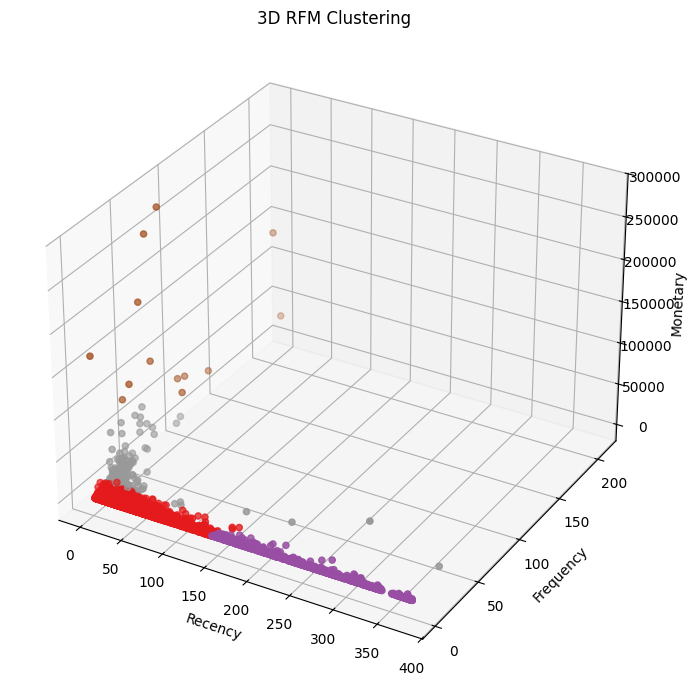

In [ ]:
# 3D plot
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(rfm['Recency'], rfm['Frequency'], rfm['Monetary'], c=rfm['Cluster_KMeans'], cmap='Set1')
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')
ax.set_title('3D RFM Clustering')
plt.tight_layout()
plt.show()

Here are the insights from your **3D RFM Clustering** plot (Recency, Frequency, Monetary):

---

###  **3D RFM Clustering Explained:**

* **Axes**:

  * **X-axis (Recency)**: How recently a customer has transacted. Lower is better.
  * **Y-axis (Frequency)**: How often they purchase. Higher is better.
  * **Z-axis (Monetary)**: Total spend. Higher is better.

* **Color-coded Clusters** :

  * **Red**
  * **Brown**
  * **Purple**
  * **Gray**



---

###  **Cluster Insights:**

#### 1. **Red Cluster (Likely "At-Risk" or "Dormant")**

* **High recency, low frequency, low monetary**
* These customers haven’t purchased recently, and they spend very little.
* Likely churned or inactive — consider win-back strategies.

#### 2. **Brown Cluster (Likely "High-Value")**

* **Low recency, high frequency, high monetary**
* These are your **best customers**.
* Very recent, loyal, and profitable.
* Focus on retention, VIP rewards, or referral programs.

#### 3. **Purple Cluster (Likely "Lost" or "Churned")**

* **Very high recency, very low frequency and monetary**
* No recent engagement; low contribution.
* Probably not worth pursuing unless reactivation is cheap.

#### 4. **Gray Cluster (Likely "Regulars" or "Potential Loyalists")**

* **Moderate recency, moderate frequency, moderate monetary**
* Stable customers with decent contribution.
* Nurture with personalized offers or loyalty incentives.

---

###  **Strategic Recommendations:**

*  **Brown (High-Value)**: Protect and grow — offer exclusive benefits.
*  **Red & Purple (At-Risk/Lost)**: Use email marketing or reactivation campaigns with offers.
*  **Gray (Potential Loyalists)**: Nurture toward high-value — upsell or offer subscriptions.

---


In [ ]:
joblib.dump(kmeans, "kmeans_rfm_model.pkl")
joblib.dump(scaler, "rfm_scaler.pkl")
rfm.to_csv("rfm_clustered.csv", index=False)

product_lookup = df[['StockCode', 'Description']].drop_duplicates().set_index('StockCode')
product_lookup.to_csv("product_lookup.csv")

pivot = df.pivot_table(index='CustomerID', columns='StockCode', values='Quantity', aggfunc='sum').fillna(0)
pivot_norm = pd.DataFrame(normalize(pivot), index=pivot.index, columns=pivot.columns)
item_similarity_matrix = pd.DataFrame(cosine_similarity(pivot_norm.T), index=pivot_norm.columns, columns=pivot_norm.columns)

['item_similarity_matrix.pkl']

In [ ]:
joblib.dump(item_similarity_matrix, "item_similarity_matrix.pkl",compress=9)

['item_similarity_matrix.pkl']